In [1]:
import os
os.environ["PUBLIC_BI_BENCHMARK"] = "D:\\semantic_data_lake\\semantic_data_lake\\data\\benchmark\\"
os.environ["WORKING_DIR"] = "D:\\semantic_data_lake\\semantic_data_lake\\"
import sys
sys.path.insert(0, "D:\\semantic_data_lake\\semantic_data_lake")
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.types import StringType, IntegerType, FloatType, DoubleType, StructType, StructField
from pyspark.sql.functions import udf, col, pandas_udf, PandasUDFType, collect_list, count, avg, lit, mean, stddev, monotonically_increasing_id, row_number
from scipy.stats import wasserstein_distance
from numpy import asarray
from pyspark.sql.window import Window
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import random
import json



In [18]:
pd.Series([1,2,3,5.7]).astype(str)

'1.0'

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 63517)
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\semantic_data_lake\lib\socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "C:\ProgramData\Anaconda3\envs\semantic_data_lake\lib\socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "C:\ProgramData\Anaconda3\envs\semantic_data_lake\lib\socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "C:\ProgramData\Anaconda3\envs\semantic_data_lake\lib\socketserver.py", line 720, in __init__
    self.handle()
  File "C:\ProgramData\Anaconda3\envs\semantic_data_lake\lib\site-packages\pyspark\accumulators.py", line 262, in handle
    poll(accum_updates)
  File "C:\ProgramData\Anaconda3\envs\semantic_data_lake\lib\site-packages\pyspark\accumulators.

# Create Spark Session

In [2]:
#spark.sparkContext.stop()
# create Spark Config
conf = SparkConf()
#conf.set("spark.executor.instances","2")
#conf.set("spark.executor.cores","2")
conf.set("spark.executor.memory", "8g")
conf.set("spark.driver.memory", "15g")
conf.set("spark.memory.offHeap.enabled", "true")
conf.set("spark.memory.offHeap.size", "16g")
#conf.set("spark.sql.execution.arrow.enabled", "true")
conf.setMaster("local[*]")
conf.setAppName("MLB-similarity-calc")
# create a SparkSession
spark = SparkSession.builder.config(conf=conf).getOrCreate()

In [3]:
from tqdm import tqdm

from itertools import permutations, combinations, combinations_with_replacement
from sklearn.metrics import classification_report

from helper_functions import print_df_to_html, translate_header_file_to_list, variations, pair_permutations_ordered, translate_datatype_file_to_list, cast_datatypes, check_attribute_completeness, compare_schemas

from data_loader.utils import get_all_publicbi_tables, load_public_bi_tables_in_spark_temp_view
import pandas as pd
pd.options.display.max_columns = None

from labeling_functions.similarity_calculations import appr0_calc_similarities,appr1_calc_similarities,appr3_calc_similarities,appr4_calc_similarities

# Load all tables as views

In [4]:
string_attributes, numeric_attributes = load_public_bi_tables_in_spark_temp_view("MLB")

Calculation_40532458112880653 is not numeric or string
Calculation_40532458117070874 is not numeric or string
Calculation_40532458117263387 is not numeric or string
Calculation_40532458113208334 is not numeric or string
Calculation_40532458117263387 is not numeric or string
Calculation_40532458113208334 is not numeric or string
Calculation_40532458112880653 is not numeric or string
Calculation_40532458117070874 is not numeric or string
Calculation_40532458112880653 is not numeric or string
Calculation_40532458117070874 is not numeric or string
Calculation_40532458112880653 is not numeric or string
Calculation_40532458117070874 is not numeric or string
Calculation_496521908233621517 is not numeric or string
Calculation_40532458112270348 is not numeric or string
Calculation_40532458116673561 is not numeric or string
Calculation_496521908233621517 is not numeric or string
Calculation_40532458112270348 is not numeric or string
Calculation_40532458116673561 is not numeric or string
Calculat

In [ ]:
appr0_calc_similarities("MLB_1", "MLB_10", numeric_attributes, ["H"])

# Boxplot of all numeric columns

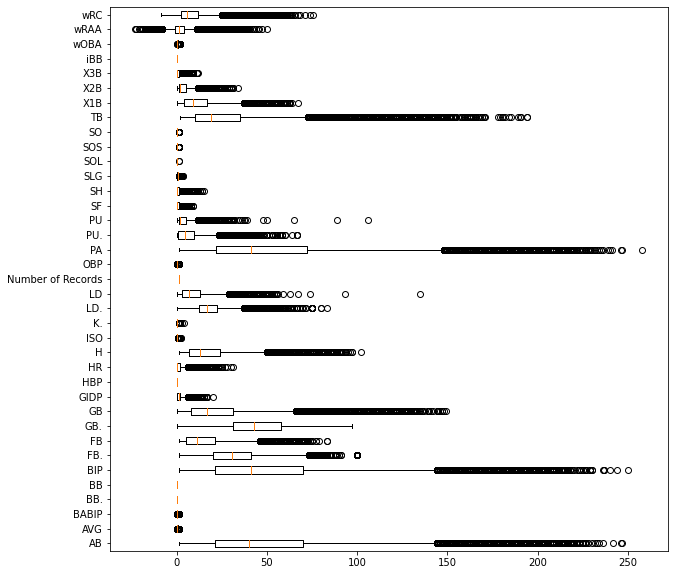

In [24]:
x_data = []
labels = []

df = spark.sql("SELECT * from MLB_1").toPandas().dropna()
for numeric_attr in numeric_attributes["MLB_1"]:
    if numeric_attr in ["year", "wRC.", "pwRC."]:
        continue
    x_data.append(df[numeric_attr].astype("float").tolist())
    labels.append(numeric_attr)

plt.figure(figsize=(10,10))
plt.boxplot(x_data, labels=labels, vert=False)
plt.show()

In [4]:
len(numeric_attributes["MLB_1"])

40

# labeling performance measure of different approches

## Appro 0

In [ ]:
def measure_performance_appr0(labeled_table, col_to_label):
    predicted_tables = []
    true_labels = []
    predicted_labels = []

    for index, curr_set in enumerate(list(combinations(get_all_publicbi_tables("MLB", True),2))):
        # if index > 1:
        #     break
        outer = curr_set[0]
        if outer != labeled_table:
            continue
        inner = curr_set[1]
        print(outer,inner)
        df = appr0_calc_similarities(outer, inner, numeric_attributes, [col_to_label])
        if df == None:
            continue
        predicted_tables.append(inner)
        df_sorted = df.select("*").sort("EMD").collect()
        true_labels.append(df_sorted[0]["INNER_ATTR"])
        predicted_labels.append(df_sorted[0]["OUTER_ATTR"])

    labeling_results={
        "labeled_table":labeled_table,
        "true_labels": true_labels,
        "predicted_labels":predicted_labels
    }
    with open(os.path.join(os.environ["WORKING_DIR"],"results","labeling_performance",f"appr0_{col_to_label}.json", "w")) as outfile:
        json.dump(labeling_results, outfile)

In [ ]:
for col_to_label in numeric_attributes["MLB_1"]:
    measure_performance_appr0("MLB_1", col_to_label)

In [5]:
# do classifiaction report 
from glob import glob

true_labels = []
predicted_labels = []
for file in glob(os.path.join(os.environ.get("WORKING_DIR"),"results", "labeling_performance","appr0*")):
    with open(file) as f:
        data = json.load(f)
    true_labels.append(data["true_labels"])
    predicted_labels.append(data["predicted_labels"])

import itertools
flatten = itertools.chain.from_iterable
true_labels = list(flatten(true_labels))
predicted_labels = list(flatten(predicted_labels))

print(classification_report(true_labels,predicted_labels))

                   precision    recall  f1-score   support

               AB       0.33      0.05      0.09        57
              AVG       0.19      0.05      0.08        59
            BABIP       0.36      0.85      0.51        59
               BB       0.00      0.00      0.00        44
              BB.       0.00      0.00      0.00        45
              BIP       0.17      0.12      0.14        49
               FB       0.30      0.29      0.29        49
              FB.       0.68      0.80      0.73        50
               GB       0.12      0.06      0.08        49
              GB.       0.77      0.80      0.78        50
             GIDP       0.25      0.43      0.31        47
                H       0.29      0.23      0.25        57
              HBP       0.17      0.10      0.13        49
               HR       0.14      0.12      0.13        49
              ISO       0.87      0.94      0.90        50
               K.       0.04      0.07      0.05       

C:\ProgramData\Anaconda3\envs\semantic_data_lake\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\semantic_data_lake\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\semantic_data_lake\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

## Appro 3

In [ ]:
def measure_performance_appro3(labeled_table, col_to_label, max_group_count):
    predicted_tables = []
    true_labels = []
    predicted_labels = []

    for index, curr_set in enumerate(list(combinations(get_all_publicbi_tables("MLB", True),2))):
        outer = curr_set[0]
        if outer != labeled_table:
            continue
        inner = curr_set[1]
        print(outer,inner)
        df = appr3_calc_similarities(outer, inner, string_attributes, numeric_attributes, max_group_count, [col_to_label])
        if df == None:
            continue
        predicted_tables.append(inner)
        df_sorted = df.select("*").sort("avg(EMD)").collect()
        true_labels.append(df_sorted[0]["INNER_ATTR"])
        predicted_labels.append(df_sorted[0]["OUTER_ATTR"])

    labeling_results={
        "labeled_table":labeled_table,
        "max_group_count": max_group_count,
        "predicted_tables":predicted_tables,
        "true_labels": true_labels,
        "predicted_labels":predicted_labels
    }
    with open(os.path.join(os.environ["WORKING_DIR"],"results","labeling_performance","appr3",f"appr3_{col_to_label}_mgrc{max_group_count}.json"), "w") as outfile:
        json.dump(labeling_results, outfile)
          

In [7]:
measure_performance_appro3("MLB_1", "H",3)

MLB_1 MLB_10


  3%|██▌                                                                                | 1/33 [00:00<00:06,  4.65it/s]

0/33


  6%|█████                                                                              | 2/33 [00:00<00:05,  5.45it/s]

1/33
2/33


 12%|██████████                                                                         | 4/33 [00:00<00:05,  5.37it/s]

3/33
4/33


 18%|███████████████                                                                    | 6/33 [00:01<00:04,  6.02it/s]

5/33
6/33


 24%|████████████████████                                                               | 8/33 [00:01<00:04,  6.24it/s]

7/33
8/33


 30%|████████████████████████▊                                                         | 10/33 [00:01<00:03,  5.75it/s]

9/33
10/33


 36%|█████████████████████████████▊                                                    | 12/33 [00:02<00:03,  6.01it/s]

11/33
12/33


 42%|██████████████████████████████████▊                                               | 14/33 [00:02<00:03,  5.81it/s]

13/33


 48%|███████████████████████████████████████▊                                          | 16/33 [00:02<00:02,  5.73it/s]

14/33
15/33
16/33


 55%|████████████████████████████████████████████▋                                     | 18/33 [00:03<00:02,  5.49it/s]

17/33


 58%|███████████████████████████████████████████████▏                                  | 19/33 [00:03<00:02,  5.33it/s]

18/33


 64%|████████████████████████████████████████████████████▏                             | 21/33 [00:03<00:02,  5.31it/s]

19/33
20/33


 67%|██████████████████████████████████████████████████████▋                           | 22/33 [00:03<00:02,  5.24it/s]

21/33


 70%|█████████████████████████████████████████████████████████▏                        | 23/33 [00:04<00:01,  5.15it/s]

22/33


 73%|███████████████████████████████████████████████████████████▋                      | 24/33 [00:04<00:01,  4.78it/s]

23/33
24/33


 76%|██████████████████████████████████████████████████████████████                    | 25/33 [00:04<00:01,  4.76it/s]

25/33


 79%|████████████████████████████████████████████████████████████████▌                 | 26/33 [00:04<00:01,  4.71it/s]

26/33


 82%|███████████████████████████████████████████████████████████████████               | 27/33 [00:05<00:01,  4.77it/s]

27/33


 85%|█████████████████████████████████████████████████████████████████████▌            | 28/33 [00:05<00:01,  4.69it/s]

28/33


 88%|████████████████████████████████████████████████████████████████████████          | 29/33 [00:05<00:00,  4.55it/s]

29/33


 91%|██████████████████████████████████████████████████████████████████████████▌       | 30/33 [00:05<00:00,  4.44it/s]

30/33


 94%|█████████████████████████████████████████████████████████████████████████████     | 31/33 [00:05<00:00,  4.45it/s]

31/33


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 32/33 [00:06<00:00,  4.40it/s]

32/33


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:06<00:00,  4.41it/s]

KeyboardInterrupt: 

In [ ]:
for col_to_label in numeric_attributes["MLB_1"]:
    measure_performance_appro3("MLB_1", col_to_label)

## Appro 4

In [5]:
def measure_performance_appro4(labeled_table, col_to_label, max_group_count):
    predicted_tables = []
    true_labels = []
    predicted_labels = []

    for index, curr_set in enumerate(list(combinations(get_all_publicbi_tables("MLB", True),2))):
        outer = curr_set[0]
        if outer != labeled_table:
            continue
        inner = curr_set[1]
        print(outer,inner)
        df = appr4_calc_similarities(outer, inner, string_attributes, numeric_attributes, max_group_count, [col_to_label])
        if df == None:
            continue
        predicted_tables.append(inner)
        df_sorted = df.sort("EMD").collect()
        true_labels.append(df_sorted[0]["INNER_ATTR"])
        predicted_labels.append(df_sorted[0]["OUTER_ATTR"])
    
    labeling_results={
        "labeled_table":labeled_table,
        "max_group_count": max_group_count,
        "predicted_tables":predicted_tables,
        "true_labels": true_labels,
        "predicted_labels":predicted_labels
    }
    
    with open(os.path.join(os.environ["WORKING_DIR"],"results","labeling_performance","appr4",f"appr4_{col_to_label}_mgrc{max_group_count}.json"), "w") as outfile:
        json.dump(labeling_results, outfile)
        

In [7]:
numeric_attributes["MLB_1"]

['AB',
 'AVG',
 'BABIP',
 'BB.',
 'BB',
 'BIP',
 'FB.',
 'FB',
 'GB.',
 'GB',
 'GIDP',
 'HBP',
 'HR',
 'H',
 'ISO',
 'K.',
 'LD.',
 'LD',
 'Number of Records',
 'OBP',
 'PA',
 'PU.',
 'PU',
 'SF',
 'SH',
 'SLG',
 'SOL',
 'SOS',
 'SO',
 'TB',
 'X1B',
 'X2B',
 'X3B',
 'iBB',
 'pwRC.',
 'wOBA',
 'wRAA',
 'wRC.',
 'wRC',
 'year']

In [6]:
#for col_to_label in numeric_attributes["MLB_1"]:
for col_to_label in ["wRC"]:
    if col_to_label in ["AB"]:
        continue
    measure_performance_appro4("MLB_1", col_to_label,3)

MLB_1 MLB_10


  0%|          | 0/33 [00:00<?, ?it/s]

MLB_1 MLB_11


  0%|          | 0/33 [00:00<?, ?it/s]

MLB_1 MLB_12


  0%|          | 0/40 [00:00<?, ?it/s]

MLB_1 MLB_13


  0%|          | 0/40 [00:00<?, ?it/s]

MLB_1 MLB_14


  0%|          | 0/40 [00:00<?, ?it/s]

MLB_1 MLB_15


  0%|          | 0/40 [00:00<?, ?it/s]

MLB_1 MLB_16


  0%|          | 0/40 [00:00<?, ?it/s]

MLB_1 MLB_17


  0%|          | 0/40 [00:00<?, ?it/s]

MLB_1 MLB_18


  0%|          | 0/40 [00:00<?, ?it/s]

MLB_1 MLB_19


  0%|          | 0/40 [00:00<?, ?it/s]

MLB_1 MLB_2


0it [00:00, ?it/s]

MLB_1 MLB_20


  0%|          | 0/40 [00:00<?, ?it/s]

MLB_1 MLB_21


  0%|          | 0/40 [00:00<?, ?it/s]

MLB_1 MLB_22


  0%|          | 0/40 [00:00<?, ?it/s]

MLB_1 MLB_23


  0%|          | 0/40 [00:00<?, ?it/s]

MLB_1 MLB_24


  0%|          | 0/40 [00:00<?, ?it/s]

MLB_1 MLB_25


  0%|          | 0/40 [00:00<?, ?it/s]

MLB_1 MLB_26


  0%|          | 0/40 [00:00<?, ?it/s]

MLB_1 MLB_27


  0%|          | 0/40 [00:00<?, ?it/s]

MLB_1 MLB_28


  0%|          | 0/40 [00:00<?, ?it/s]

MLB_1 MLB_29


  0%|          | 0/40 [00:00<?, ?it/s]

MLB_1 MLB_3


0it [00:00, ?it/s]

MLB_1 MLB_30


  0%|          | 0/40 [00:00<?, ?it/s]

MLB_1 MLB_31


  0%|          | 0/40 [00:00<?, ?it/s]

Py4JJavaError: An error occurred while calling o98047.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 4428.0 failed 1 times, most recent failure: Lost task 0.0 in stage 4428.0 (TID 186542) (lag-n-langeneck.mshome.net executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:182)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:107)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:119)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:145)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.evaluate(BatchEvalPythonExec.scala:70)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:130)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:863)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:863)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(DualStackPlainSocketImpl.java:131)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:535)
	at java.net.PlainSocketImpl.accept(PlainSocketImpl.java:189)
	at java.net.ServerSocket.implAccept(ServerSocket.java:545)
	at java.net.ServerSocket.accept(ServerSocket.java:513)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:174)
	... 24 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2253)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2202)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2201)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2201)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1078)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1078)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1078)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2440)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2382)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2371)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2202)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2223)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2242)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2267)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1030)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1029)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:390)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:3519)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3687)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:772)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3685)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3516)
	at sun.reflect.GeneratedMethodAccessor138.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:182)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:107)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:119)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:145)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.evaluate(BatchEvalPythonExec.scala:70)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:130)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:863)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:863)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(DualStackPlainSocketImpl.java:131)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:535)
	at java.net.PlainSocketImpl.accept(PlainSocketImpl.java:189)
	at java.net.ServerSocket.implAccept(ServerSocket.java:545)
	at java.net.ServerSocket.accept(ServerSocket.java:513)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:174)
	... 24 more
